<a href="https://colab.research.google.com/github/Nimesh33390/u_net/blob/main/u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"nimeshparmar","key":"d1c3dff8cd05b7afd6bd9541e7ff36e7"}'}

In [2]:
import os
import shutil

# Create the .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move kaggle.json to the .kaggle directory
shutil.move('kaggle.json', '/root/.kaggle/')

# Set permissions
os.chmod('/root/.kaggle/kaggle.json', 600)

In [3]:
!pip install kaggle

In [5]:
!kaggle competitions download -c carvana-image-masking-challenge

^C


In [6]:
!kaggle competitions download -c carvana-image-masking-challenge --force

^C


In [4]:
!kaggle competitions download -c carvana-image-masking-challenge -f train.zip

 96% 389M/405M [00:00<00:00, 436MB/s]
100% 405M/405M [00:00<00:00, 517MB/s]


In [5]:
import zipfile

with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('carvana')

In [6]:
!kaggle competitions download -c carvana-image-masking-challenge -f train_masks.zip

  0% 0.00/29.1M [00:00<?, ?B/s]
100% 29.1M/29.1M [00:00<00:00, 1.31GB/s]


In [7]:
import zipfile

with zipfile.ZipFile('train_masks.zip', 'r') as zip_ref:
    zip_ref.extractall('carvana')

In [8]:
!rm train.zip

In [9]:
!rm train_masks.zip

In [15]:
!rm -r train

In [10]:
# For Google Colab, usually already installed
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [11]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch 10/10: 100%|██████████| 1272/1272 [04:21<00:00,  4.86it/s, loss=0.00822]


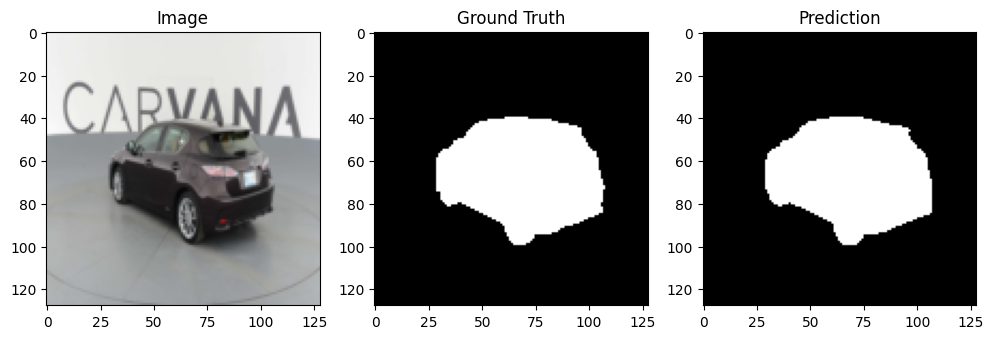

In [12]:
# Step 2: Import libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from torchvision import transforms
from tqdm import tqdm

# Step 3: Define Dataset class
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.replace('.jpg', '_mask.gif')
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert mask to binary 0/1
        mask = (mask > 0).float()

        return image, mask

# Step 4: Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Step 5: Create dataset and dataloader
# train_dataset = CarvanaDataset('train/', 'train_masks/', transform=transform)
train_dataset = CarvanaDataset('carvana/train/', 'carvana/train_masks/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Step 6: Load pretrained U-Net model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)

# Step 7: Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Step 8: Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)  # [B, H, W]

        # Squeeze the mask tensor to match the output shape
        masks = masks.squeeze(1) # [B, H, W]


        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

# Step 9: Visualize some predictions
def visualize(image, mask, pred_mask):
    image = image.permute(1, 2, 0).cpu().numpy()
    mask = mask.cpu().numpy()
    pred_mask = (pred_mask.cpu().numpy() > 0.5).astype(np.uint8)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Ground Truth')
    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title('Prediction')
    plt.show()

# Get a batch for visualization
model.eval()
with torch.no_grad():
    images, masks = next(iter(train_loader))
    images = images.to(device)
    outputs = model(images)
    preds = torch.sigmoid(outputs).squeeze(1)

# Visualize first image in batch
visualize(images[0], masks[0].squeeze(0), preds[0]) # Squeeze mask for visualization as well

In [13]:
torch.save(model.state_dict(), "unet_carvana.pth")

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
save_path = '/content/drive/MyDrive/Machine_Learning/unet_carvana.pth'


In [20]:
torch.save(model.state_dict(), save_path)

RuntimeError: Parent directory /content/drive/MyDrive/Machine_Learning does not exist.

In [21]:
import os

# Create the directory if it doesn't exist
save_dir = os.path.dirname(save_path)
os.makedirs(save_dir, exist_ok=True)

torch.save(model.state_dict(), save_path)

In [22]:
import os

save_path = '/content/drive/MyDrive/models'
os.makedirs(save_path, exist_ok=True)


In [23]:
model_save_path = os.path.join(save_path, 'unet_carvana.pth')

torch.save(model.state_dict(), model_save_path)
